# Feature Engineering - Telco Churn Prediction

This notebook contains the feature engineering and data preparation for the churn prediction project.

## 1. Library Imports

In [26]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# For data splitting
from sklearn.model_selection import train_test_split

# Note: SMOTE import removed due to compatibility issues with current sklearn version
# We'll handle class imbalance with alternative methods if needed

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('Set2')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# To display all columns
pd.set_option('display.max_columns', None)

## 2. Data Loading

In [27]:
# Import dataset
df = pd.read_csv('../data/telco_churn_data.csv')

# View first rows
print(f"Dataset dimensions: {df.shape}")
df.head()

Dataset dimensions: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Data Cleaning and Processing

In [28]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [29]:
# Check missing values
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_pct
})

print("Missing values by column:")
missing_df[missing_df['Missing Values'] > 0]

Missing values by column:


,Missing Values,Percentage (%)


In [30]:
# Check if TotalCharges needs numeric conversion
print(f"TotalCharges data type: {df['TotalCharges'].dtype}")

# Convert TotalCharges to numeric if needed
if df['TotalCharges'].dtype == 'object':
    # Check problematic values
    print("Non-numeric values in TotalCharges:")
    print(df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]['TotalCharges'].unique())
    
    # Replace empty spaces with NaN
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    # Fill NaN values in TotalCharges with mean or other appropriate value
    # For new customers (tenure=0), we can use 0 or minimum MonthlyCharges
    mask_new_customers = df['tenure'] == 0
    
    # For new customers, TotalCharges should equal MonthlyCharges
    df.loc[mask_new_customers & df['TotalCharges'].isna(), 'TotalCharges'] = \
        df.loc[mask_new_customers & df['TotalCharges'].isna(), 'MonthlyCharges']
    
    # For remaining cases (if any), use mean
    df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)
    
    print(f"\nTotalCharges data type after conversion: {df['TotalCharges'].dtype}")
    print(f"Missing values in TotalCharges after treatment: {df['TotalCharges'].isna().sum()}")

TotalCharges data type: object
Non-numeric values in TotalCharges:
[' ']

TotalCharges data type after conversion: float64
Missing values in TotalCharges after treatment: 0


In [31]:
# Convert SeniorCitizen to categorical type
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

print("Unique values in SeniorCitizen after conversion:")
df['SeniorCitizen'].value_counts()

Unique values in SeniorCitizen after conversion:


SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64

## 4. Feature Engineering

In [32]:
# Remove ID column as it's not relevant for modeling
df = df.drop('customerID', axis=1)

In [33]:
# Create feature to group tenure time
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], 
                           labels=['0-12 months', '13-24 months', '25-36 months', 
                                   '37-48 months', '49-60 months', '61-72 months'])

# Check new feature
df['tenure_group'].value_counts().sort_index()

tenure_group
0-12 months     2175
13-24 months    1024
25-36 months     832
37-48 months     762
49-60 months     832
61-72 months    1407
Name: count, dtype: int64

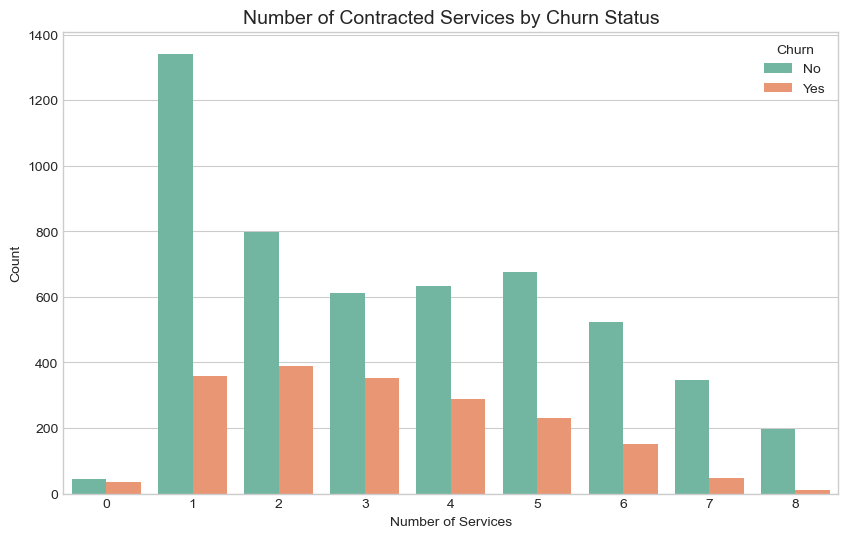

In [34]:
# Create feature for count of contracted services
services = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Initialize service count
df['num_services'] = 0

# Count active services
for service in services:
    df['num_services'] += (df[service] == 'Yes').astype(int)

# Check distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='num_services', hue='Churn', data=df)
plt.title('Number of Contracted Services by Churn Status', fontsize=14)
plt.xlabel('Number of Services')
plt.ylabel('Count')
plt.show()

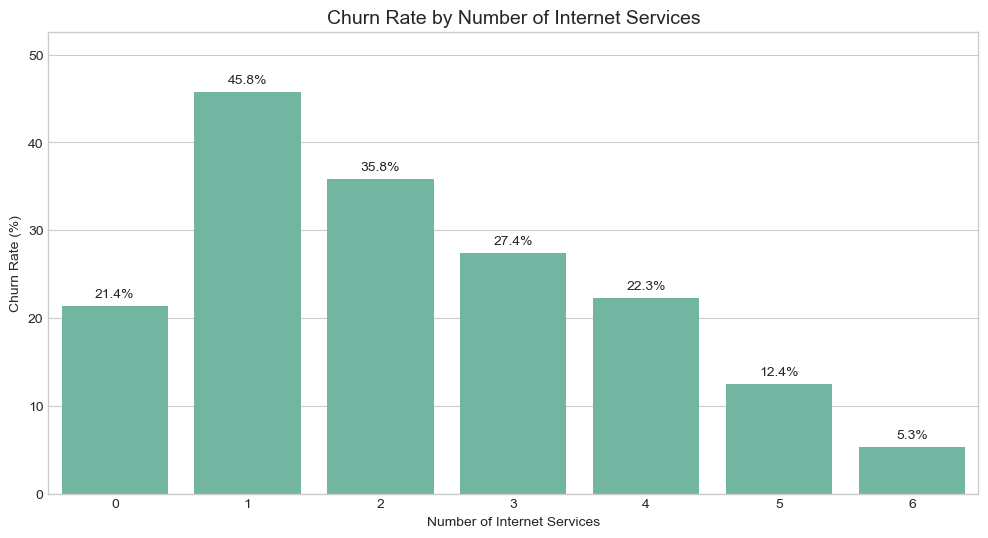

In [35]:
# Create feature for internet services
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                     'TechSupport', 'StreamingTV', 'StreamingMovies']

# Initialize internet services count
df['num_internet_services'] = 0

# Count active internet services
for service in internet_services:
    df['num_internet_services'] += (df[service] == 'Yes').astype(int)

# Group by number of internet services
internet_services_churn = df.groupby('num_internet_services')['Churn'].value_counts(normalize=True).unstack() * 100

plt.figure(figsize=(12, 6))
if 'Yes' in internet_services_churn.columns:
    ax = sns.barplot(x=internet_services_churn.index, y=internet_services_churn['Yes'])
    
    # Add values
    for i, val in enumerate(internet_services_churn['Yes']):
        ax.text(i, val + 1, f'{val:.1f}%', ha='center')
    
    plt.title('Churn Rate by Number of Internet Services', fontsize=14)
    plt.xlabel('Number of Internet Services')
    plt.ylabel('Churn Rate (%)')
    plt.ylim(0, max(internet_services_churn['Yes']) * 1.15)
    plt.show()

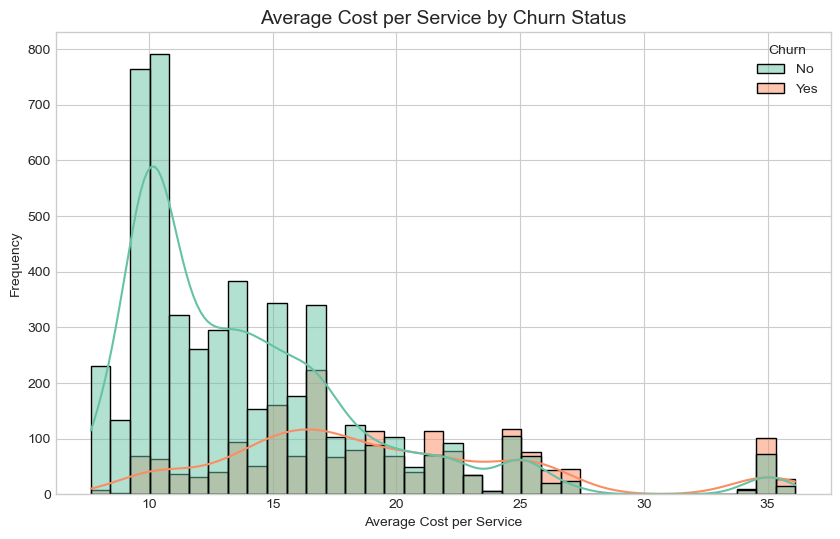

In [36]:
# Create feature for monthly value rate per service
df['avg_cost_per_service'] = df['MonthlyCharges'] / (df['num_services'] + 1)  # Add 1 to avoid division by zero

# View distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='avg_cost_per_service', hue='Churn', kde=True)
plt.title('Average Cost per Service by Churn Status', fontsize=14)
plt.xlabel('Average Cost per Service')
plt.ylabel('Frequency')
plt.show()

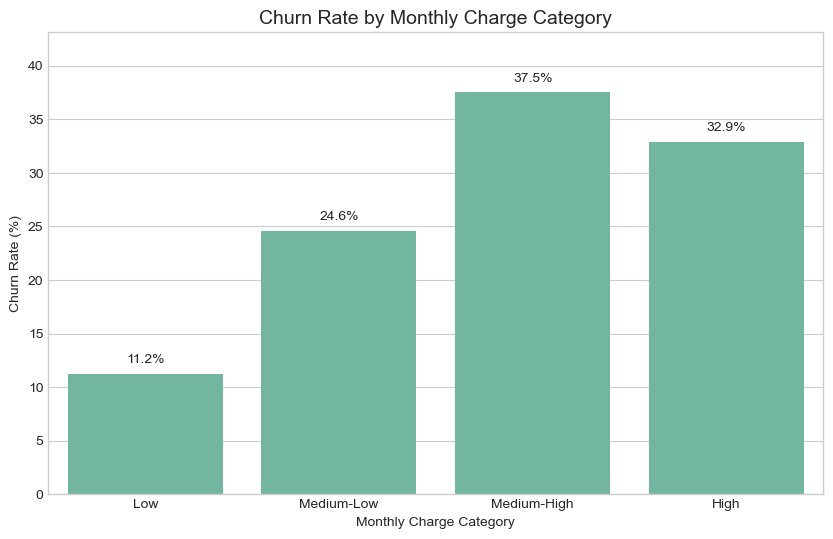

In [37]:
# Create feature for monthly value categories
df['monthly_charge_category'] = pd.qcut(df['MonthlyCharges'], q=4, 
                                        labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# Churn rate by monthly value category
monthly_charge_churn = df.groupby('monthly_charge_category')['Churn'].value_counts(normalize=True).unstack() * 100

plt.figure(figsize=(10, 6))
if 'Yes' in monthly_charge_churn.columns:
    ax = sns.barplot(x=monthly_charge_churn.index, y=monthly_charge_churn['Yes'])
    
    # Add values
    for i, val in enumerate(monthly_charge_churn['Yes']):
        ax.text(i, val + 1, f'{val:.1f}%', ha='center')
    
    plt.title('Churn Rate by Monthly Charge Category', fontsize=14)
    plt.xlabel('Monthly Charge Category')
    plt.ylabel('Churn Rate (%)')
    plt.ylim(0, max(monthly_charge_churn['Yes']) * 1.15)
    plt.show()

In [38]:
# Create feature indicating if customer has streaming services
df['has_streaming'] = ((df['StreamingTV'] == 'Yes') | (df['StreamingMovies'] == 'Yes')).astype(int)

# Create feature indicating if customer has security services
df['has_security'] = ((df['OnlineSecurity'] == 'Yes') | (df['OnlineBackup'] == 'Yes') | 
                      (df['DeviceProtection'] == 'Yes') | (df['TechSupport'] == 'Yes')).astype(int)

# Create feature combining contract type and payment method
df['contract_payment'] = df['Contract'] + '_' + df['PaymentMethod'].apply(lambda x: x.replace(' ', '_'))

# Check new features
print("has_streaming distribution:")
print(df['has_streaming'].value_counts())

print("\nhas_security distribution:")
print(df['has_security'].value_counts())

has_streaming distribution:
has_streaming
0    3544
1    3499
Name: count, dtype: int64

has_security distribution:
has_security
1    4250
0    2793
Name: count, dtype: int64


## 5. Preparation for Modeling

In [39]:
# Separate dependent and independent variables
X = df.drop('Churn', axis=1)
y = df['Churn']

# Convert target variable to binary
y = y.map({'No': 0, 'Yes': 1})

In [40]:
# Identify categorical and numerical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical variables: {len(categorical_cols)}")
print(f"Numerical variables: {len(numerical_cols)}")

Categorical variables: 19
Numerical variables: 6


In [41]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set dimensions (X_train): {X_train.shape}")
print(f"Test set dimensions (X_test): {X_test.shape}")
print(f"Target variable distribution in training set:\n{pd.Series(y_train).value_counts(normalize=True) * 100}")
print(f"\nTarget variable distribution in test set:\n{pd.Series(y_test).value_counts(normalize=True) * 100}")

Training set dimensions (X_train): (5634, 27)
Test set dimensions (X_test): (1409, 27)
Target variable distribution in training set:
Churn
0    73.464679
1    26.535321
Name: proportion, dtype: float64

Target variable distribution in test set:
Churn
0    73.456352
1    26.543648
Name: proportion, dtype: float64


In [42]:
# Create preprocessing pipeline
# 1. For numerical variables: imputation and standardization
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. For categorical variables: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combining transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing on training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"X_train dimensions after preprocessing: {X_train_processed.shape}")
print(f"X_test dimensions after preprocessing: {X_test_processed.shape}")

X_train dimensions after preprocessing: (5634, 71)
X_test dimensions after preprocessing: (1409, 71)


In [43]:
# Check target variable imbalance
print("Target variable distribution:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)

# Apply SMOTE to handle imbalance (if needed)
# Import SMOTE first


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("\nTarget variable distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True) * 100)

print(f"\nX_train dimensions after SMOTE: {X_train_resampled.shape}")

Target variable distribution:
Churn
0    73.464679
1    26.535321
Name: proportion, dtype: float64

Target variable distribution after SMOTE:
Churn
0    50.0
1    50.0
Name: proportion, dtype: float64

X_train dimensions after SMOTE: (8278, 71)


## 6. Export Processed Data

In [44]:
# Save processed data and preprocessing pipeline
import pickle
import os

# Create directory for processed data if it doesn't exist
processed_data_dir = '../data/processed'
if not os.path.exists(processed_data_dir):
    os.makedirs(processed_data_dir)

# Save preprocessor
with open(f"{processed_data_dir}/preprocessor.pkl", 'wb') as f:
    pickle.dump(preprocessor, f)

# Save processed data
np.save(f"{processed_data_dir}/X_train_processed.npy", X_train_processed)
np.save(f"{processed_data_dir}/X_test_processed.npy", X_test_processed)
np.save(f"{processed_data_dir}/y_train.npy", y_train)
np.save(f"{processed_data_dir}/y_test.npy", y_test)

# Save SMOTE balanced data
np.save(f"{processed_data_dir}/X_train_resampled.npy", X_train_resampled)
np.save(f"{processed_data_dir}/y_train_resampled.npy", y_train_resampled)

# Save column lists for reference
with open(f"{processed_data_dir}/feature_names.pkl", 'wb') as f:
    pickle.dump({
        'numerical_cols': numerical_cols,
        'categorical_cols': categorical_cols
    }, f)

print("Processed data and preprocessing pipeline saved successfully!")

Processed data and preprocessing pipeline saved successfully!


## 7. Created Features Summary

In [45]:
# Display summary of all created features
new_features = ['tenure_group', 'num_services', 'num_internet_services', 
                'avg_cost_per_service', 'monthly_charge_category',
                'has_streaming', 'has_security', 'contract_payment']

print("Summary of created features:")
for feature in new_features:
    if feature in df.columns:
        if df[feature].dtype == 'object' or df[feature].dtype.name == 'category':
            n_unique = df[feature].nunique()
            print(f"{feature}: {n_unique} unique values (categorical)")
        else:
            print(f"{feature}: Mean = {df[feature].mean():.2f}, Standard Deviation = {df[feature].std():.2f} (numerical)")

Summary of created features:
tenure_group: 6 unique values (categorical)
num_services: Mean = 3.36, Standard Deviation = 2.06 (numerical)
num_internet_services: Mean = 2.04, Standard Deviation = 1.85 (numerical)
avg_cost_per_service: Mean = 15.41, Standard Deviation = 5.99 (numerical)
monthly_charge_category: 4 unique values (categorical)
has_streaming: Mean = 0.50, Standard Deviation = 0.50 (numerical)
has_security: Mean = 0.60, Standard Deviation = 0.49 (numerical)
contract_payment: 12 unique values (categorical)


## 8. Feature Importance Analysis (Preliminary)

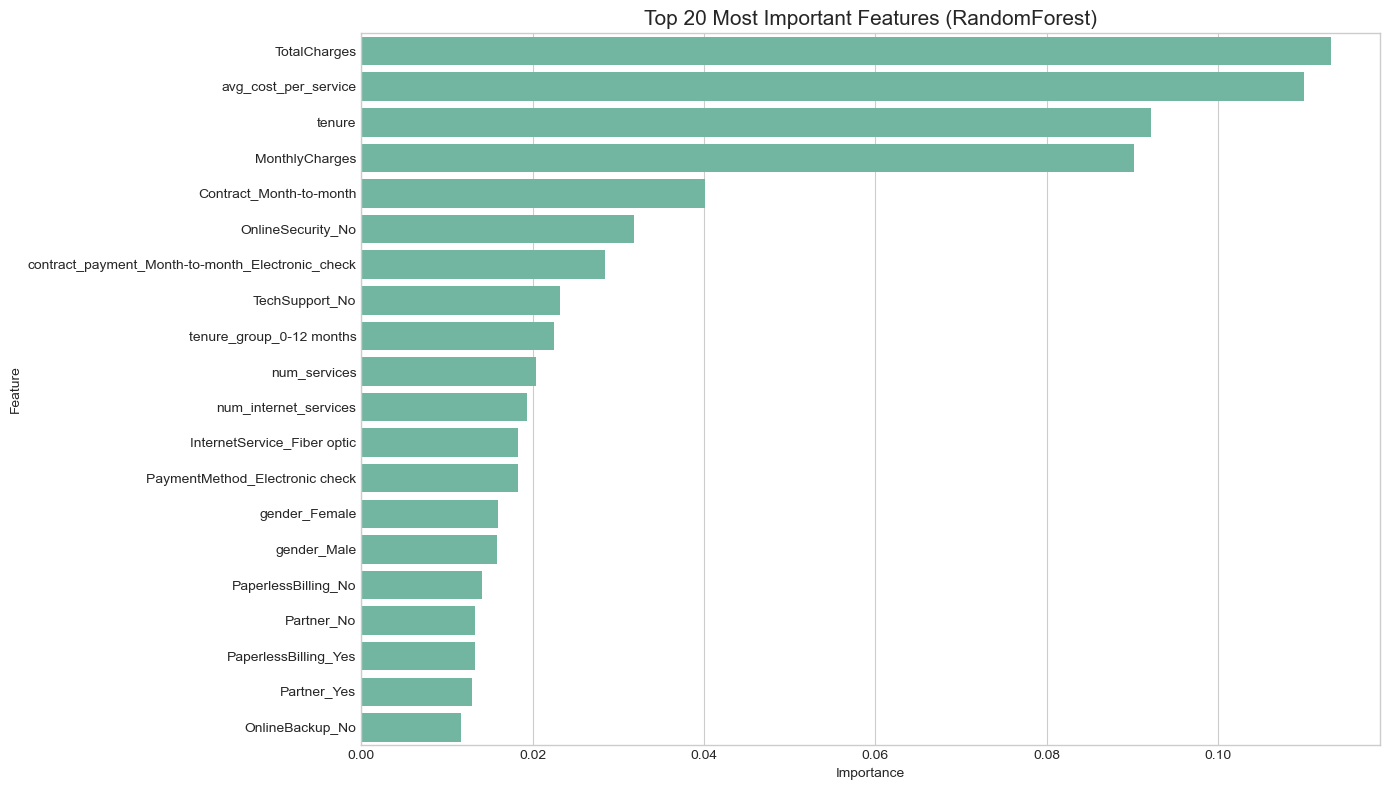

In [46]:
# Preliminary feature importance analysis using a simple model
from sklearn.ensemble import RandomForestClassifier

# Train a RandomForest model for importance analysis
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_processed, y_train)

# Get feature names after transformation
feature_names = []

# Names of numerical features
feature_names.extend(numerical_cols)

# Names of categorical features after one-hot encoding
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_features = []
for i, col in enumerate(categorical_cols):
    categorical_features.extend([f"{col}_{val}" for val in ohe.categories_[i]])
feature_names.extend(categorical_features)

# Check if number of features matches
if len(feature_names) != X_train_processed.shape[1]:
    print(f"Warning: Number of feature names ({len(feature_names)}) doesn't match X_train_processed shape ({X_train_processed.shape[1]})")
    # Use indices as feature names
    feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

# Get feature importance
feature_importances = pd.DataFrame({
    'feature': feature_names[:X_train_processed.shape[1]],
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize most important features
plt.figure(figsize=(14, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Most Important Features (RandomForest)', fontsize=15)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 9. Next Steps

### Next steps for model development:

1. **Basic Modeling**: Implement and compare models like Random Forest, XGBoost, LightGBM, etc.

2. **Hyperparameter Optimization**: Use techniques like GridSearchCV or Optuna to optimize model hyperparameters.

3. **Cross Validation**: Implement cross validation to assess model robustness.

4. **Model Ensemble**: Explore ensemble techniques to improve predictive performance.

5. **In-depth Analysis**: Investigate important features and their interactions.

6. **Probability Calibration**: Calibrate output probabilities to ensure reliable predictions.

7. **Evaluation and Monitoring**: Establish metrics and procedures for continuous model evaluation.